<a href="https://colab.research.google.com/github/FlorianHilbert/Code-Bachelorarbeit/blob/main/Abbildung_7_Bildsegmentierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Abmessungen des Bildes: (640, 625)
[[0.6745098  0.61176471 0.59215686 ... 0.79607843 0.82745098 0.89019608]
 [0.50980392 0.45490196 0.45098039 ... 0.76078431 0.78823529 0.77647059]
 [0.49803922 0.44705882 0.44313725 ... 0.72156863 0.75294118 0.77647059]
 ...
 [0.31764706 0.22352941 0.22745098 ... 0.4        0.39607843 0.45098039]
 [0.30588235 0.21568627 0.22352941 ... 0.39607843 0.38431373 0.39215686]
 [0.41568627 0.30196078 0.28627451 ... 0.43529412 0.41568627 0.49411765]]


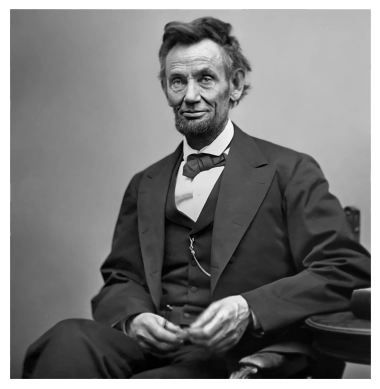

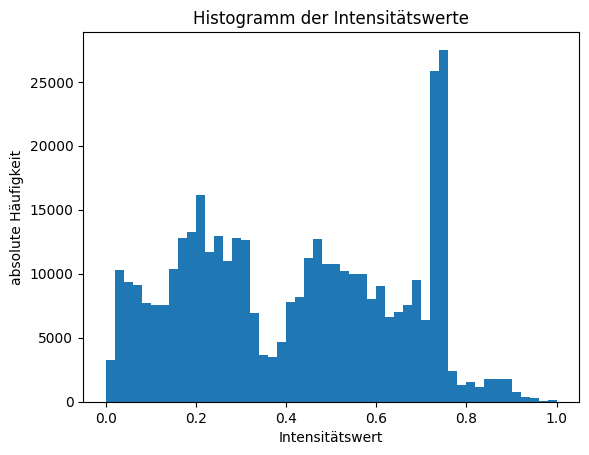

In [4]:
import numpy as np
from skimage import io, util
import matplotlib.pyplot as plt

Graustufenbild = util.img_as_float(io.imread('/content/abraham_lincoln_graustufen.jpg', as_gray=True)) #laden des Bildes als Graustufenbild
print("Abmessungen des Bildes:", Graustufenbild.shape)
print(Graustufenbild) #Ausgabe des Bildes als Matrix, jeder Eintrag entspricht der Intensität des zugehörigen Pixels, wobei 1 = Weiß und 0 = Schwarz gilt
plt.imshow(Graustufenbild, cmap='gray') #Ausgabe des Bildes als Graustufenbild
plt.axis('off')
plt.show()

# Für eine geeignete Wahl von I_c ist es nötig sich die Verteilung der Intensitätswerte anzusehen.
#Dazu wandeln wir die Matrix in eine eindimensionale Liste von Werten um und geben dann das Histogramm der Intensitätswerte aus.
values = Graustufenbild.flatten()
plt.hist(values, bins=50)
plt.xlabel('Intensitätswert')
plt.ylabel('absolute Häufigkeit')
plt.title('Histogramm der Intensitätswerte')
plt.show()

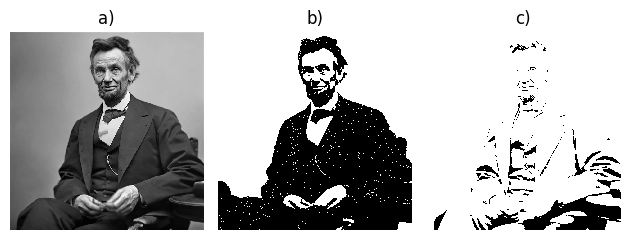

In [5]:
#Implementierung des Segmentierungsalgorithmus

from scipy.signal import convolve2d

#angepasste Version von F, die auch auf Vektoren (elementeweise) funktioniert
def F(Parameter_a, Parameter_b, z):
    return np.where(z < 0, 0, np.exp(-Parameter_b * z) - np.exp(-Parameter_a * z))

#Implementierung von f_b, wird später für die iterative Berechnung der y_n-Werte benötigt
def f_b(Parameter_b, z):
    return 1 - np.exp(-Parameter_b * z)

#Der folgende Code ist im Rahmen der Optimierung mit ChatGPT in Bezug auf die Rechenzeit entstanden, wurde jedoch leicht modifiziert

#Implementierung des Radius für die lokale Kopplung der neuronalen Netzwerke
#Dazu erstellt man eine Matrix der Größe (2*Radius+1)×(2*Radius+1)
#Diese besitzt in der Mitte den Wert Null und darum herum in Rautenform den Wert Eins.
#Die Größe der Raute bestimmt sich aus dem als Funktionsargument eingegebenen Radius

def Kern(Radius):
    Maße = 2 * Radius + 1
    Kern = np.zeros((Maße, Maße), dtype=float)
    for i in range(Maße):
        for j in range(Maße):
            if abs(i - Radius) + abs(j - Radius) <= Radius:
                Kern[i, j] = 1
    Kern[Radius, Radius] = 0  # mittiges Pixel null setzen
    return Kern

#print(Kern(2))

#Implementierung des Segmentierungsverfahrens
#Zuerst Implementierung der iterativen Berechnung des Zustandes z_{n+1} mit der Formel aus Abschnitt 4.4
#Für die Segmentierungsentscheidung werden dann die ersten zu_verwerfende_Iterationen Iterationen verworfen
#In den anschließenden Messiterationen wird geprüft, ob die kumulierte betragsmäßige Änderung des Zustandes z_n unterhalb der Schwelle Theta verbleibt
#Ist dies der Fall wird dieser Pixel dem Objekt (und damit der Wert 0) zugeordnet. Anderfalls erfolgt die Klassifizierung als Hintergrund (Wert = 1)

def Segmentierungsalgorithmus(z0, y0, a, b, er_Radius, he_Radius, zu_verwerfende_Iterationen, Messiterationen, externer_Reiz, Theta):

    Höhe, Breite = externer_Reiz.shape
    z = np.full((Höhe, Breite), z0)

    # Erzeuge der Faltungskerne für die lokale Kopplung
    Kern_er = Kern(er_Radius)
    Kern_he = Kern(he_Radius)

    num_er = Kern_er.sum()
    num_he = Kern_he.sum()
    #print(num_ex, num_in)

    # anfängliche Iterationen, die später verworfen werden. Damit entfernen wir vorübergehende Schwankungen und erhalten das langfristige Verhalten
    for it in range(zu_verwerfende_Iterationen):
        #print(it)
        #in der ersten Iteration Initialisierung von der Matrix y, die überall den Eintrag y0 besitzt
        if it == 0:
            y = np.full((Höhe, Breite), y0, dtype=float)
        #print(y)

        #Hier findet der größte Teil der Optimierung statt. Anstatt den Wert jeden einzelnen Pixels iterativ zu aktualisieren, erledigen wir es nun mittels einer Faltung und der zuvor
        #definierten Kerne
        #Dabei garantiert mode='same', dass die Ausgabe sum_z_ex wieder die gleiche Größe wie z hat.
        sum_z_er = convolve2d(z, Kern_er, mode='same')
        sum_y_er = convolve2d(y, Kern_er, mode='same')
        sum_y_he = convolve2d(y, Kern_he, mode='same')

        mean_z_er = sum_z_er / num_er if num_er != 0 else 0
        mean_y_er = sum_y_er / num_er if num_er != 0 else 0
        mean_y_he = sum_y_he / num_he if num_he != 0 else 0

        argument = z + mean_z_er + mean_y_er - mean_y_he + externer_Reiz

        new_z = F(a, b, argument)
        y = f_b(b, z) # Aktualisierung für die nächste Iteration, noch auf dem alten z, wegen y_n = f_b(z_{n-1})
        z = new_z  # Aktualisierung für die nächste Iteration

    # Messiterationen
    #Initialisierung einer Nullmatrix, in die wir für jeden Pixel die kummulierte Änderung abspeichern werden
    kumulierte_Änderung = np.zeros_like(z)

    for it in range(Messiterationen):

        sum_z_er = convolve2d(z, Kern_er, mode='same')
        sum_y_er = convolve2d(y, Kern_er, mode='same')
        sum_y_he = convolve2d(y, Kern_he, mode='same')

        mean_z_er = sum_z_er / num_er if num_er != 0 else 0
        mean_y_er = sum_y_er / num_er if num_er != 0 else 0
        mean_y_he = sum_y_he / num_he if num_he != 0 else 0

        argument = z + mean_z_er + mean_y_er - mean_y_he + externer_Reiz
        new_z = F(a, b, argument)

        # Addiere die betragsmäßige Änderung pro Pixel in dieser Iteration
        kumulierte_Änderung += np.abs(new_z - z)
        y = f_b(b, z) # Aktualisierung für die nächste Iteration, noch auf dem alten z, wegen y_n = f_b(z_{n-1})
        z = new_z  # Aktualisierung für die nächste Iteration

    # Erzeuge Ausgabematrix, die das Ergebnis der Segmentierung enthält: 1, wenn summierte Änderung > Theta, sonst 0
    Ausgabematrix = (kumulierte_Änderung < Theta).astype(np.uint8)
    #print(Ausgabematrix)
    return Ausgabematrix


# Parameterwahl:

z0 = 0.4  # Anfangswert für z
y0 = 0.2  # Anfangswert für y (nur für Iteration 0 relevant)
a, b = 30, 15
ex_radius = 2
in_radius = 1
zu_verwerfende_Iterationen = 150      # Erste 150 Iterationen verwerfen
Messiterationen = 4   # Nächste 4 Iterationen zur Messung der Änderung
Theta = 0.002       # Schwellwert für Klassifizierungsentscheidung

Segmentierungsergebnis = Segmentierungsalgorithmus(z0, y0, a, b, ex_radius, in_radius, zu_verwerfende_Iterationen, Messiterationen, Graustufenbild, Theta)
Segmentierungsergebnis_ungekoppelt = Segmentierungsalgorithmus(z0, y0, a, b, 0, 0, zu_verwerfende_Iterationen, Messiterationen, Graustufenbild, Theta)

# Ausgabe Originalbild
plt.subplot(1, 3, 1)
plt.imshow(Graustufenbild, cmap='gray', interpolation='nearest') #mit interpolation='nearest' stellen wir sicher, dass keine Glättung bei der Skalierung stattfindet, entfernt man diese Bedingung sehen die Bilder deutlich weicher aus und bspw. sind die als Objekt klassifizierten Bereich nicht von einzelnen abweichenden Pixeln durchsetzt
plt.axis('off')
plt.title('a)')

# Segmentierungsergebnis lokal gekoppelte Netzwerke
plt.subplot(1, 3, 2)
plt.imshow(Segmentierungsergebnis, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('b)')

# Segmentierungsergebnis ungekoppelte Netzwerke
plt.subplot(1, 3, 3)
plt.imshow(Segmentierungsergebnis_ungekoppelt, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('c)')

plt.tight_layout()
plt.show()